## Library

In [61]:
import os
import glob
import numpy as np
# from ccdproc import ImageFileCollection
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, hstack
from scipy.optimize import curve_fit

In [62]:
##	Plot presetting
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 500
plt.rc('font', family='serif')
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## 7DT

In [63]:
import sys
sys.path.append('..')
from util.helper import *
from util.sdtpy import *
register_custom_filters_on_speclite('../util')

Use `med25nm`, `med50nm`, `broad` as `group_name`


In [64]:
#	Subsequent filter info [AA]
bandmin=4000
bandmax=9000
bandwidth=250
bandstep=125
#	Maximum transmission of each filters
bandrsp=0.95
#	Wavelength bin [AA]
lammin=1000
lammax=10000
lamres=1000
#	Seeing Condition
seeing = 1.5
#
exptime = 180

D             : 50.5cm
D_obscuration : 29.8cm
Deff          : 40.770cm


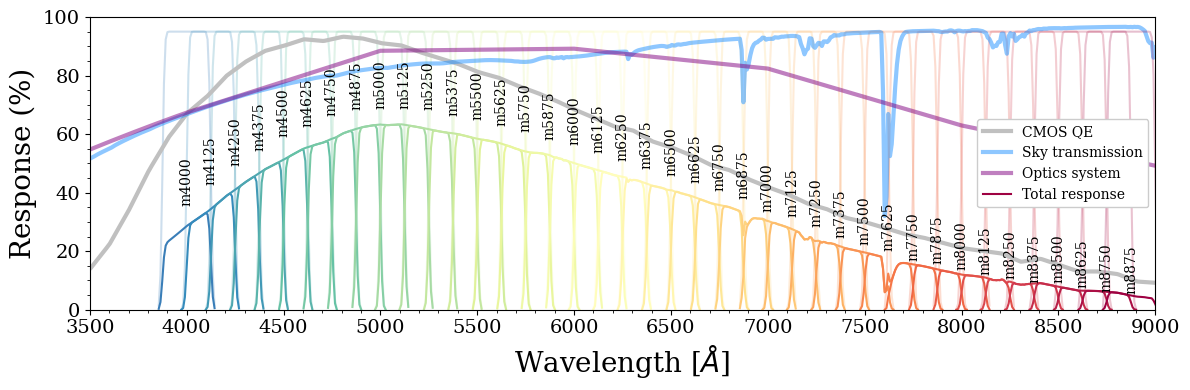

In [65]:
#	Exposure Time [s]
sdt = SevenDT()
sdt.echo_optics()
filterset = sdt.generate_filterset(bandmin=bandmin, bandmax=bandmax, bandwidth=bandwidth, bandstep=bandstep, bandrsp=bandrsp, lammin=lammin, lammax=lammax, lamres=lamres)
T_qe = sdt.get_CMOS_IMX455_QE()
sdt.get_optics()
s = sdt.get_sky()
sdt.smooth_sky()
totrsptbl = sdt.calculate_response()
Npix_ptsrc, Narcsec_ptsrc = sdt.get_phot_aperture(exptime=exptime, fwhm_seeing=seeing, optfactor=1.0, verbose=False)
outbl_ris = sdt.get_depth_table(Nsigma=5)
sdt.get_speclite()

## Initial Setting

In [66]:
filter_match_dict = {
	#
	"m400": "7DT01",
	"m425": "7DT01",
	#
	"m450": "7DT02",
	"m475": "7DT02",
	#
	"m500": "7DT03",
	"m525": "7DT03",
	#
	"m550": "7DT04",
	"m575": "7DT04",
	#
	"m600": "7DT05",
	"m625": "7DT05",
	#
	"m600": "7DT06",
	"m625": "7DT06",
	#
	"m700": "7DT07",
	"m725": "7DT07",
	#
	"m750": "7DT08",
	"m775": "7DT08",
	#
	"m800": "7DT09",
	"m825": "7DT09",
	#
	"m850": "7DT10",
	"m875": "7DT10",
}

In [80]:
objs_to_remove = ['LTT3218', 'LTT4364', 'HILT600']
outputs = sorted(glob.glob('../output/comparison/*/output.csv'))
print(f"{len(outputs)} found")

12 found


In [85]:
ref_tables = sorted(glob.glob('../output/comparison/*/gaia.csv'))

ref_table_list = []

for ref_table in ref_tables:
	check = True
	for obj in objs_to_remove:
		if obj in ref_table:
			check = False
	if check:
		ref_table_list.append(Table.read(ref_table))

reftbl = vstack(ref_table_list)

Text(0, 0.5, 'Number')

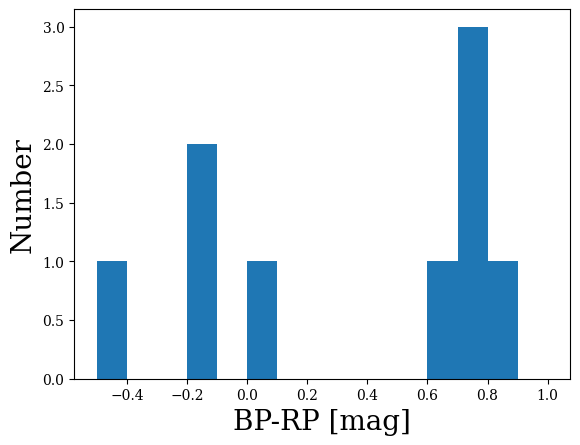

In [90]:
plt.hist(reftbl['bp_rp'], bins=np.arange(-0.5, 1.0+0.1, 0.1))
plt.xlabel('BP-RP [mag]')
plt.ylabel(f"Number")

In [81]:
tablelist = []

for output in outputs:
	_outbl = Table.read(output)
	obj = output.split('/')[3]
	if obj not in objs_to_remove:
		#	
		_newtbl = Table()
		_newtbl['obj'] = [obj]
		for filte in _outbl['Wavelength']:
			indx_filte = np.where(_outbl['Wavelength'] == filte)
			_newtbl[f"mag_7dt_{filte}"] = _outbl['7DT Mag'][indx_filte].item()
			_newtbl[f"magerr_7dt_{filte}"] = _outbl['7DT MagErr'][indx_filte].item()
			_newtbl[f"mag_gaia_{filte}"] = _outbl['Gaia Mag'][indx_filte].item()
			_newtbl[f"mag_calspec_{filte}"] = _outbl['CALSPEC Mag'][indx_filte].item()
			_newtbl[f'mag_offset_{filte}'] = _newtbl[f"mag_7dt_{filte}"] - _newtbl[f"mag_calspec_{filte}"]
		# print(_newtbl)
		tablelist.append(_newtbl)


In [82]:
newtbl = vstack(tablelist)
newtbl

obj,mag_7dt_m425,magerr_7dt_m425,mag_gaia_m425,mag_calspec_m425,mag_offset_m425,mag_7dt_m450,magerr_7dt_m450,mag_gaia_m450,mag_calspec_m450,mag_offset_m450,mag_7dt_m475,magerr_7dt_m475,mag_gaia_m475,mag_calspec_m475,mag_offset_m475,mag_7dt_m500,magerr_7dt_m500,mag_gaia_m500,mag_calspec_m500,mag_offset_m500,mag_7dt_m525,magerr_7dt_m525,mag_gaia_m525,mag_calspec_m525,mag_offset_m525,mag_7dt_m575,magerr_7dt_m575,mag_gaia_m575,mag_calspec_m575,mag_offset_m575,mag_7dt_m600,magerr_7dt_m600,mag_gaia_m600,mag_calspec_m600,mag_offset_m600,mag_7dt_m625,magerr_7dt_m625,mag_gaia_m625,mag_calspec_m625,mag_offset_m625,mag_7dt_m650,magerr_7dt_m650,mag_gaia_m650,mag_calspec_m650,mag_offset_m650,mag_7dt_m675,magerr_7dt_m675,mag_gaia_m675,mag_calspec_m675,mag_offset_m675,mag_7dt_m700,magerr_7dt_m700,mag_gaia_m700,mag_calspec_m700,mag_offset_m700,mag_7dt_m725,magerr_7dt_m725,mag_gaia_m725,mag_calspec_m725,mag_offset_m725,mag_7dt_m750,magerr_7dt_m750,mag_gaia_m750,mag_calspec_m750,mag_offset_m750,mag_7dt_m775,magerr_7dt_m775,mag_gaia_m775,mag_calspec_m775,mag_offset_m775,mag_7dt_m800,magerr_7dt_m800,mag_gaia_m800,mag_calspec_m800,mag_offset_m800,mag_7dt_m850,magerr_7dt_m850,mag_gaia_m850,mag_calspec_m850,mag_offset_m850,mag_7dt_m400,magerr_7dt_m400,mag_gaia_m400,mag_calspec_m400,mag_offset_m400,mag_7dt_m550,magerr_7dt_m550,mag_gaia_m550,mag_calspec_m550,mag_offset_m550
str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
EG21,11.258,0.012,11.261618752320864,11.28161016771055,-0.02361016771055091,11.096,0.011,11.123519634051895,11.16431961844741,-0.06831961844740952,11.185,0.011,11.27196089214437,11.312315849134864,-0.12731584913486316,11.321,0.018,11.328676641170482,11.350394385027236,-0.02939438502723668,11.259,0.014,11.272876777728236,11.309998311813509,-0.050998311813508224,11.377,0.014,11.414273777303428,11.43867531828376,-0.061675318283759495,11.438,0.013,11.499487924875787,11.511323044185733,-0.07332304418573266,11.495,0.016,11.572528989396623,11.571817311953325,-0.07681731195332553,11.719,0.017,11.776258637525821,11.771534049915665,-0.052534049915665904,11.702,0.016,11.71278851337528,11.71697189513895,-0.014971895138950586,11.693,0.021,11.736460024722398,11.761515810244905,-0.0685158102449055,11.774,0.021,11.793652147250917,11.82968043661054,-0.05568043661054034,11.8,0.024,11.84631271925715,11.893591681688205,-0.09359168168820453,11.853,0.027,11.898204209429373,11.953398057605071,-0.10039805760507114,11.909,0.027,11.95486004716063,11.947886645302482,-0.038886645302481426,12.024,0.038,12.062049412657096,12.053965807118585,-0.029965807118585985,--,--,--,--,--,--,--,--,--,--
Feige110,11.376,0.019,11.376315435891378,11.368212485436118,0.0077875145638817145,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,11.311,0.016,11.286752473006494,11.29487065050385,0.016129349496150525,--,--,--,--,--
LTT1020,12.004,0.016,12.022216350859559,12.011990058882452,-0.007990058882452189,11.811,0.016,11.82115242014526,11.834195162566658,-0.023195162566658212,--,--,--,--,--,11.625,0.011,11.625986754184574,11.634728523923798,-0.009728523923797638,11.55,0.011,11.554830286267695,11.557769347009199,-0.007769347009197958,--,--,--,--,--,-

In [83]:
ct = 0
for key in newtbl.keys():
	if 'offset' in key:
		ct+=1
print(ct)

18


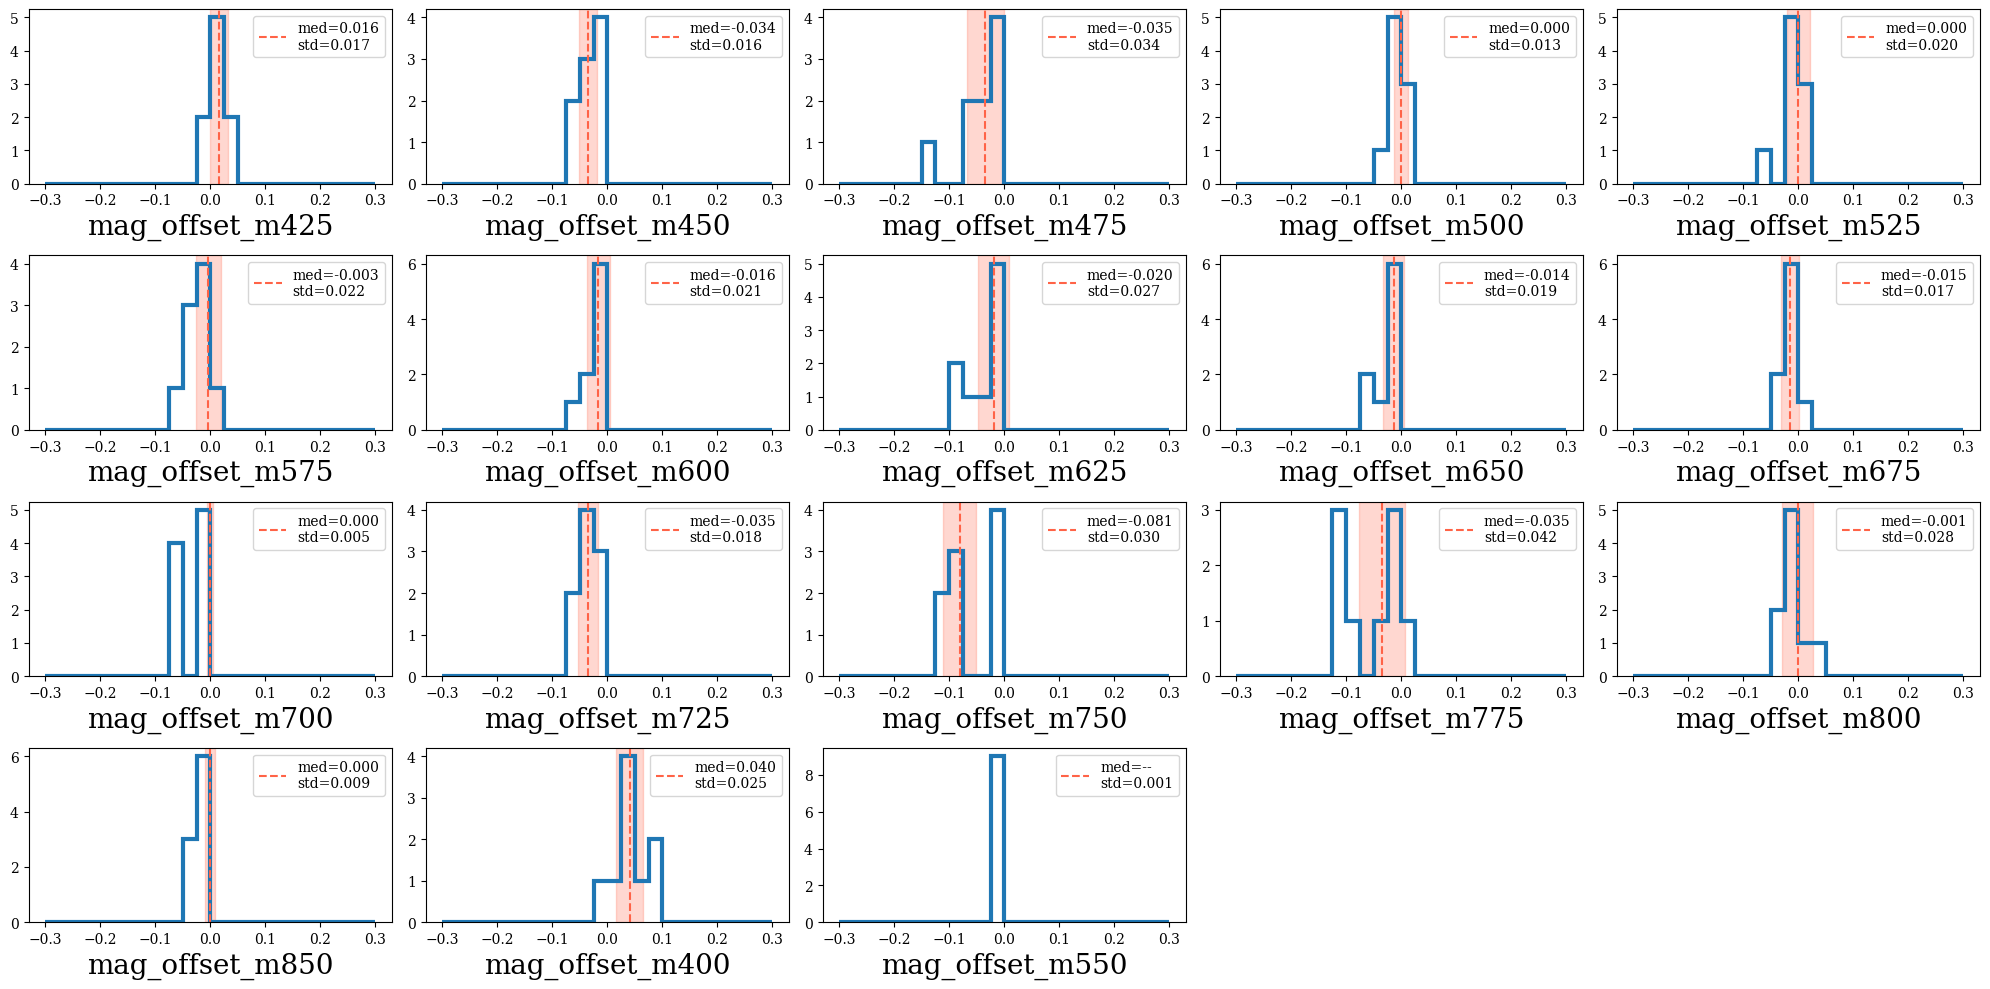

In [84]:
bins_offset = np.arange(-0.3, +0.3+0.025, 0.025)

ct = 0
fig = plt.figure(figsize=(20, 10))
for key in newtbl.keys():
	if 'offset' in key:
		ct += 1
		plt.subplot(4, 5, ct)
		values = newtbl[key]
		med_val = np.median(values)
		std_val = np.std(values)
		plt.hist(values, bins=bins_offset, histtype='step', lw=3)# label=f"{len(values)} sources")
		plt.axvline(x=med_val, ls='--', c='tomato', label=f"med={med_val:.3f}\nstd={std_val:.3f}")
		plt.axvspan(xmin=med_val-std_val, xmax=med_val+std_val, color='tomato', alpha=0.25, zorder=0)
		plt.xlabel(key)
		plt.legend(loc='upper right', fontsize=10)

plt.tight_layout()

In [40]:
field_table = Table.read('../conf/standard_field.csv')

for ii, obj in enumerate(field_table['obj']):
	if '-' not in obj:
		ground_tables = sorted(glob.glob(f"../data/Xshooter/*{obj.lower()}*")) + \
			sorted(glob.glob(f"../data/Xshooter/*{obj.upper()}*")) + \
			sorted(glob.glob(f"../data/SPSS/*{obj.lower()}*")) + \
			sorted(glob.glob(f"../data/SPSS/*{obj.upper()}*")) + \
			sorted(glob.glob(f"../data/CALSPEC/*{obj.lower()}*")) + \
			sorted(glob.glob(f"../data/CALSPEC/*{obj.upper()}*"))
	else:
		ground_tables = sorted(glob.glob(f"../data/Xshooter/*{obj.lower().replace('-', '_')}*")) + \
			sorted(glob.glob(f"../data/Xshooter/*{obj.upper().replace('-', '_')}*")) + \
			sorted(glob.glob(f"../data/SPSS/*{obj.lower().replace('-', '_')}*")) + \
			sorted(glob.glob(f"../data/SPSS/*{obj.upper().replace('-', '_')}*")) + \
			sorted(glob.glob(f"../data/CALSPEC/*{obj.lower().replace('-', '_')}*")) + \
			sorted(glob.glob(f"../data/CALSPEC/*{obj.upper().replace('-', '_')}*"))
	n_gtable = len(ground_tables)
	
	print(f"[{ii:0>3}] {obj}\t{n_gtable}")

[000] CD-34241	0
[001] EG21	1
[002] Feige110	3
[003] G114-25	0
[004] GJ2066	0
[005] GJ70	0
[006] HD199525	0
[007] HD209241	0
[008] HD270422	0
[009] HD270477	0
[010] HD271747	0
[011] HD271759	0
[012] HD271783	0
[013] HG7-15	0
[014] HILT600	1
[015] HIP28618	0
[016] LTT1020	1
[017] LTT1788	1
[018] LTT2415	1
[019] LTT3218	1
[020] LTT377	0
[021] LTT3864	1
[022] LTT4364	1
[023] LTT7987	2
[024] LTT9239	1
[025] LTT9491	1
[026] SDSS00832	0
[027] SDSS03532	0
[028] SDSS03932	0
[029] WD0046+051	0
[030] WD0047-524	0
[031] WD0050-332	0
[032] WD0104-331	0
[033] WD0106-358	0
[034] WD0109-264	0
[035] WD0123-262	0
[036] WD0227+050	0
[037] WD0316-849	0
[038] WD0435-088	0
[039] WD0446-789	0
[040] WD0455-282	0
[041] WD0501-289	0
[042] WD0552-041	0
[043] WD0604-203	0
[044] WD0621-376	0
[045] WD0646-253	0
[046] WD0721-276	0
[047] WD0749-383	0
[048] WD2039-682	1
[049] WD2105-820	0
[050] WD2115-560	0
[051] WD2152-548	0
[052] WD2211-495	0
[053] WD2216-657	0
[054] WD2309+105	0
[055] WD2331-475	0
[056] WD2359-434

In [41]:
nn = 25

obj = field_table['obj'][nn]

# obj = "LTT7987"
# obj = "HD270422"
# obj = "EG21"
radec = field_table['radec'][field_table['obj']==obj].item()
print(obj, radec)
# radec = '20 10 56.849 -30 13 06.63' # Wrong Position?
# radec = '20 10 56.2032 -30 13 12.656'
# date = '20231015'

# obj = "LTT9491"
# radec = '23 19 35.388 -17 05 28.47'
# date = '20231015'

LTT9491 23 19 35 -17 05 28


In [42]:
lam_min = 3750
lam_max = 9000

In [43]:
path_data = f"../data/7DT/{obj}"
# path_ground = f"../data/Xshooter/f{obj}.dat"
# path_ground = f"../data/SPSS/f{obj.lower()}.dat"
# path_ground = f"../data/CALSPEC/{obj.lower()}_002.fits"

In [44]:
if '-' not in obj:
	ground_tables = sorted(glob.glob(f"../data/Xshooter/*{obj.lower()}*")) + \
		sorted(glob.glob(f"../data/Xshooter/*{obj.upper()}*")) + \
		sorted(glob.glob(f"../data/SPSS/*{obj.lower()}*")) + \
		sorted(glob.glob(f"../data/SPSS/*{obj.upper()}*")) + \
		sorted(glob.glob(f"../data/CALSPEC/*{obj.lower()}*")) + \
		sorted(glob.glob(f"../data/CALSPEC/*{obj.upper()}*"))
else:
	ground_tables = sorted(glob.glob(f"../data/Xshooter/*{obj.lower().replace('-', '_')}*")) + \
		sorted(glob.glob(f"../data/Xshooter/*{obj.upper().replace('-', '_')}*")) + \
		sorted(glob.glob(f"../data/SPSS/*{obj.lower().replace('-', '_')}*")) + \
		sorted(glob.glob(f"../data/SPSS/*{obj.upper().replace('-', '_')}*")) + \
		sorted(glob.glob(f"../data/CALSPEC/*{obj.lower().replace('-', '_')}*")) + \
		sorted(glob.glob(f"../data/CALSPEC/*{obj.upper().replace('-', '_')}*"))


print(f"{len(ground_tables)} tables found")
for _tbl in ground_tables:
	print(_tbl)

path_ground = ground_tables[0]

1 tables found
../data/SPSS/fltt9491.dat


In [45]:
path_save = f"../output/comparison/{obj}"
if not os.path.exists(path_save):
	os.makedirs(path_save)

In [46]:
reftbl = Table.read(f"{path_data}/gaiaxp_dr3_synphot_{obj}.csv")

In [47]:
c = SkyCoord(radec, unit=(u.hourangle, u.deg))
c_ref = SkyCoord(reftbl['ra'], reftbl['dec'], unit="deg")

In [48]:
table = Table.read(f'{path_data}/summary.csv')
for nn, _cat in enumerate(table['cat']):
	newcat = f"{path_data}/{os.path.basename(_cat)}"
	if os.path.exists(newcat):
		table['cat'][nn] = newcat
	else:
		print(f"No data!")
table[:1]

file,simple,bitpix,naxis,naxis1,naxis2,extend,equinox,mjd-obs,radesys,ctype1,cunit1,crval1,crpix1,cd1_1,cd1_2,ctype2,cunit2,crval2,crpix2,cd2_1,cd2_2,exptime,gain,saturate,softname,softvers,softdate,softauth,softinst,author,origin,date,combinet,imagetyp,xbinning,ybinning,egain,xpixsz,ypixsz,instrume,set-temp,ccd-temp,telescop,focallen,focratio,ra,dec,pierside,siteelev,sitelat,sitelong,fwheel,filter,object,objctra,objctdec,objctrot,focname,focpos,focuspos,focussz,roworder,swcreate,resampt1,centert1,pscalet1,resampt2,centert2,pscalet2,date-obs,date-loc,exposure,centalt,centaz,airmass,mjd,jd,photime,seeing,peeing,ellip,elong,skysig,skyval,refcat,maglow,magup,stdnumb,auto,aper,aper_1,aper_2,aper_3,aper_4,aper_5,zp_auto,ezp_auto,ul3_auto,ul5_auto,zp_0,ezp_0,ul3_0,ul5_0,zp_1,ezp_1,ul3_1,ul5_1,zp_2,ezp_2,ul3_2,ul5_2,zp_3,ezp_3,ul3_3,ul5_3,zp_4,ezp_4,ul3_4,ul5_4,zp_5,ezp_5,ul3_5,ul5_5,comment,cat
str94,str4,int64,int64,int64,int64,str4,float64,float64,str4,str8,str3,float64,float64,float64,float64,str8,str3,float64,float64,float64,float64,int64,float64,float64,str5,str6,str10,str23,str22,str17,str16,str19,str6,str5,int64,int64,float64,float64,float64,str19,float64,float64,str5,float64,float64,float64,float64,str4,float64,float64,float64,str19,str4,str7,str8,str9,float64,str20,int64,int64,float64,str8,str19,str8,str6,str6,str8,str6,str6,str23,str26,int64,float64,float64,float64,float64,float64,str10,float64,float64,float64,float64,float64,float64,str6,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str63,str65
/large_data/processed/LTT9491/7DT01/u/calib_7DT01_LTT9491_20231015_041930_u_600.com.fits,True,-32,2,10200,6800,True,2000.0,60232.92361111,ICRS,RA---TAN,deg,349.8958333333,5100.5,-0.0001402777777778,0.0,DEC--TAN,deg,-17.09111111111,3400.5,0.0,0.0001402777777778,600,2750.0,1077.609781324,SWarp,2.41.5,2023-10-20,2010-2012 IAP/CNRS/UPMC,IAP http://www.iap.fr,Gregory S.H. Paek,proton.snu.ac.kr,2023-12-25T21:59:14,MEDIAN,LIGHT,1,1,0.2561904788017,3.76,3.76,Moravian USB Camera,-10.0,-9.955574035645,7DT01,1537.0,3.0,349.8958337893,-17.09111598782,East,1600.0,-30.471,-70.765,Moravian USB Filter,u,LTT9491,23 19 35,-17 05 28,0.0,PlaneWave Focuser (v,7566,7566,1.0,TOP-DOWN,N.I.N.A. 2.2.0.9001,LANCZOS3,MANUAL,MANUAL,LANCZOS3,MANUAL,MANUAL,2023-10-15T04:19:30.703,2023-10-15T01:19:30.703000,600,61.52222431300751,292.033314054515,1.1372530951327,60232.1802164699,2460232.68021647,2023-12-26,2.211,4.379,0.042,1.044,0.035,-0.005,GaiaXP,12.0,20.0,33,0.0,5.894,8.757,13.136,5.941,9.901,19.802,20.54,0.037,0.0,0.0,19.778,0.095,20.44,19.885,20.185,0.084,20.417,19.862,20.45,0.045,20.242,19.687,19.788,0.089,20.441,19.886,20.298,0.059,20.396,19.841,20.559,0.031,19.905,19.351,",,, Propagated FITS keywords,, Axis-dependent config parameters",../data/7DT/LTT9491/calib_7DT01_LTT9491_20231015_041930_u_600.com


- CALSPEC

In [49]:
if 'dat' in path_ground:
	fmt = 'ascii'
elif 'csv' in path_ground:
	fmt = 'csv'
elif 'fits' in path_ground:
	fmt = 'fits'

caltbl = Table.read(path_ground, format=fmt)
if 'SPSS' in path_ground:
	caltbl['col2'] /= 10**16

print(f"{len(caltbl)} rows table")

134 rows table


In [50]:
base_name, ext = os.path.splitext(path_ground)

col1,col2,col3,col4
float64,float64,float64,float64
3300.0,2.3174e-14,8.4178,50.0
3350.0,2.3287999999999998e-14,8.7176,50.0
3400.0,2.2712e-14,8.7579,50.0
3450.0,2.1616e-14,8.5822,50.0
3500.0,2.1334999999999998e-14,8.7176,50.0


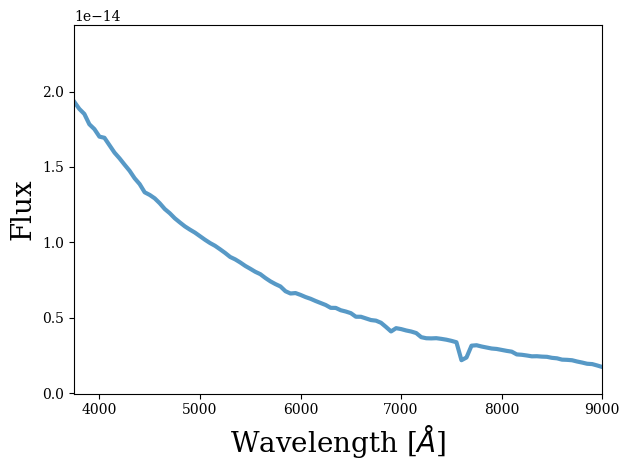

In [51]:
# caltbl.keys()
# plt.plot(caltbl['col1'], caltbl['col3'], lw=3, alpha=0.75)
# plt.plot(caltbl['WAVELENGTH'], caltbl['FLUX'], lw=3, alpha=0.75)
lamkey, flamkey = caltbl.keys()[0], caltbl.keys()[1]

plt.plot(caltbl[lamkey], caltbl[flamkey], lw=3, alpha=0.75)
plt.xlim(lam_min, lam_max)
plt.xlabel(r"Wavelength [$\AA$]")
plt.ylabel("Flux")
plt.tight_layout()
plt.savefig(f"{path_save}/{os.path.basename(path_ground).replace(ext, '.png')}")
caltbl[:5]

In [52]:
# caltbl['FLUX'].value*flamunit
fnu = convert_flam2fnu(caltbl[flamkey].value*flamunit, caltbl[lamkey].value*lamunit)
mag = fnu.to(u.ABmag)

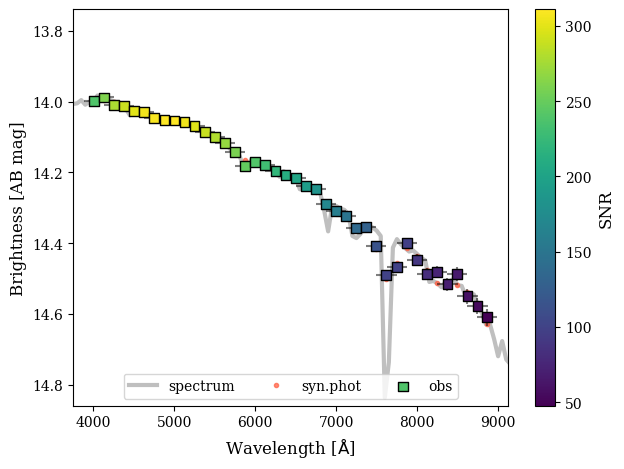

In [53]:
# flam_calspec, lam_calspec = caltbl['col2']*flamunit, caltbl['col1']*lamunit
flam_calspec, lam_calspec = caltbl[flamkey].value*flamunit, caltbl[lamkey].value*lamunit
mobstbl = sdt.get_synphot2obs(flam_calspec, lam_calspec, z=None, z0=None, figure=True)
mobstbl['filter'] = [filte[:-1] for filte in mobstbl['filter']]
plt.savefig(f"{path_save}/7dt_synphot.png")

## Comparison

In [54]:
basemagkey = 'MAG_AUTO'
basemagerrkey = 'MAGERR_AUTO'


In [55]:
mfilterlist = [filte for filte in np.unique(table['filter']) if 'm' in filte]
mfilterlist

['m400',
 'm425',
 'm450',
 'm475',
 'm500',
 'm525',
 'm550',
 'm575',
 'm600',
 'm625',
 'm650',
 'm675',
 'm725',
 'm750',
 'm775',
 'm800']

In [56]:
# filte = mfilterlist[0]

result_dict = {}

for filte in mfilterlist:

	magkey = f"{basemagkey}_{filte}"
	magerrkey = f"{basemagerrkey}_{filte}"

	_table = table[table['filter']==filte]
	nn = 0
	# incat = _table['cat'][nn]
	inim = _table['file'][nn]
	incat = f"../data/7DT/{obj}/{os.path.basename(inim).replace('fits', 'phot.cat')}"
	# filte = _table['filter'][nn]
	airmass = _table['airmass'][nn]
	intbl = Table.read(incat, format='ascii')
	c_cat = SkyCoord(intbl['ALPHA_J2000'], intbl['DELTA_J2000'], unit="deg")
	##	Matching
	indx_in, sep_in, _ = c.match_to_catalog_sky(c_cat)
	indx_ref, sep_ref, _ = c.match_to_catalog_sky(c_ref)

	mag_calspec = mobstbl['magapp'][mobstbl['filter']==filte].item()
	mag_7dt = intbl[magkey][indx_in]
	magerr_7dt = intbl[magerrkey][indx_in]
	mag_gaia = reftbl[f"{filte}_mag"][indx_ref]

	# print('seperation', sep_in.arcsec, sep_ref.arcsec)
	# print('7DT:', mag_7dt, '+/-', magerr_7dt)
	# print('Gaia:', mag_gaia)
	# print('CALSPEC:', mag_calspec)

	result_dict[filte] = {
		'7DT': {
			'mag': mag_7dt,
			'magerr': magerr_7dt
		},
		'Gaia': {
			'mag': mag_gaia,
		},
		'CALSPEC': {
			'mag': mag_calspec,
		},
	}

In [57]:
# 각 파장 및 관측소별 데이터를 저장할 리스트 초기화
wavelengths = []
mag_7DT = []
magerr_7DT = []
mag_Gaia = []
mag_CALSPEC = []

# 사전 데이터를 반복하여 리스트에 값 추가
for wave, data in result_dict.items():
    wavelengths.append(wave)
    mag_7DT.append(data['7DT'].get('mag', None))
    magerr_7DT.append(data['7DT'].get('magerr', None))
    mag_Gaia.append(data['Gaia'].get('mag', None))
    mag_CALSPEC.append(data['CALSPEC'].get('mag', None))

# Astropy 테이블 생성
outbl = Table([wavelengths, mag_7DT, magerr_7DT, mag_Gaia, mag_CALSPEC], 
              names=('Wavelength', '7DT Mag', '7DT MagErr', 'Gaia Mag', 'CALSPEC Mag'))

outbl.write(f"{path_save}/output.csv", format='csv', overwrite=True)
print(outbl)

Wavelength 7DT Mag 7DT MagErr      Gaia Mag         CALSPEC Mag    
---------- ------- ---------- ------------------ ------------------
      m400  14.036      0.017  13.98156179849149 13.996513397138537
      m425  14.018      0.014 13.990518324609845 14.002316844356592
      m450  13.991      0.011 14.000337830522163 14.028535778049168
      m475  13.981      0.026 14.014691548534707  14.04373580663793
      m500  14.059      0.011  14.02961881054383 14.055864628185738
      m525  14.079      0.012 14.050055178487177 14.071101200410716
      m550   14.09       0.01  14.09060116340138 14.098843406553407
      m575  14.141      0.012 14.119650047624042 14.144330218129097
      m600  14.162      0.022 14.186912738489788 14.173878350731053
      m625  14.176      0.018 14.164890838306526 14.195567362656416
      m650  14.216      0.022 14.235154818823538  14.22266919511421
      m675  14.278      0.023 14.259676951005297  14.25559562017336
      m725  14.361      0.029  14.33102407490339

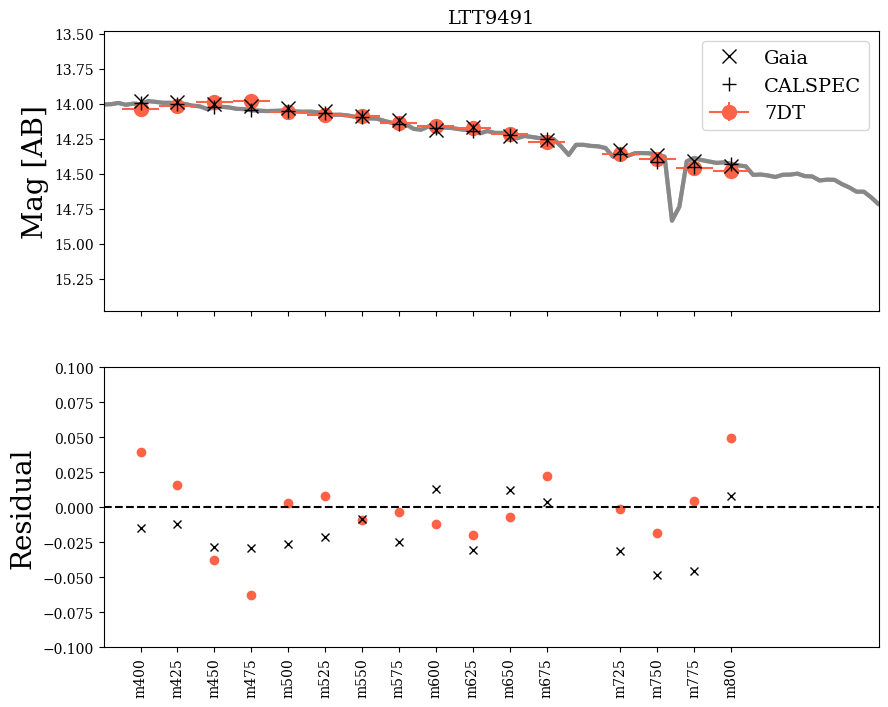

In [58]:
filterticks = [filte for filte in list(result_dict.keys())]
# filterticks
lamarr = [int(filte[1:]) for filte in filterticks]
# fig = plt.figure(figsize=(10, 4))

# 그래프와 잔차 플롯을 위한 서브플롯 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# 기존 그래프
ax1.plot(lam_calspec/10., mag, color='grey', lw=3, alpha=0.75, zorder=0)

# plt.plot(lam_calspec/10., mag, color='grey', lw=3, alpha=0.75, zorder=0,)
ax1.plot(lam_calspec/10., mag, color='grey', lw=3, alpha=0.75, zorder=0,)

for ff, filte in enumerate(filterticks):
	#	7DT
	mag_7dt = result_dict[filte]['7DT']['mag']
	magerr_7dt = result_dict[filte]['7DT']['magerr']
	#	Gaia
	mag_gaia = result_dict[filte]['Gaia']['mag']
	#	CALSPEC
	mag_calspec = result_dict[filte]['CALSPEC']['mag']

	#
	lam = lamarr[ff]
	if ff == 0:
		ax1.errorbar([lam], [mag_7dt], xerr=[12.5], yerr=[magerr_7dt], color='tomato', marker='o', label='7DT', ms=10)
		ax1.plot([lam], [mag_gaia], 'x', color='k', zorder=999, label='Gaia', ms=10)
		ax1.plot([lam], [mag_calspec], '+', color='k', zorder=999, label='CALSPEC', ms=10)
	else:
		ax1.errorbar([lam], [mag_7dt], xerr=[12.5], yerr=[magerr_7dt], color='tomato', marker='o', ms=10)
		ax1.plot([lam], [mag_gaia], 'x', color='k', zorder=999, ms=10)
		ax1.plot([lam], [mag_calspec], '+', color='k', zorder=999, ms=10)


# yl, yu = plt.ylim()
yu = mag_7dt+1.0
yl = mag_7dt-1.0
ax1.set_ylim([yu, yl])
ax1.set_xlim([lam_min/10, lam_max/10])
ax1.set_ylabel('Mag [AB]')
# _ = plt.xticks(lamarr, filterticks, rotation=90)
ax1.set_title(f"{obj}")
ax1.legend(loc='upper right', fontsize=14)
# plt.tight_layout()

# 잔차 플롯
residuals_7dt = []
residuals_gaia = []
residuals_calspec = []
for ff, filte in enumerate(filterticks):
    mag_7dt = result_dict[filte]['7DT']['mag']
    mag_gaia = result_dict[filte]['Gaia']['mag']
    mag_calspec = result_dict[filte]['CALSPEC']['mag']
    lam = lamarr[ff]

	#	7DT
    residual_7dt = mag_7dt - mag_calspec
    residuals_7dt.append(residual_7dt)
    ax2.plot([lam], [residual_7dt], 'o', color='tomato')

	#	Gaia
    residual_gaia = mag_gaia - mag_calspec
    residuals_gaia.append(residual_gaia)
    ax2.plot([lam], [residual_gaia], 'x', color='k')

	#	CALSPEC
    # residual_calspec = mag_gaia - mag_calspec
    # residuals_gaia.append(residual_gaia)
    # ax2.plot([lam], [residual_gaia], 'x', color='k')

ax2.axhline(0, color='k', linestyle='--')  # 잔차가 0인 선 추가

# 축 설정
ax2.set_xlim([lam_min/10, lam_max/10])
ax2.set_ylim([-0.1, +0.1])
ax2.set_ylabel('Residual')
_ = ax2.set_xticks(lamarr)
_ = ax2.set_xticklabels(filterticks, rotation=90)

plt.savefig(f"{path_save}/result_comp.png")


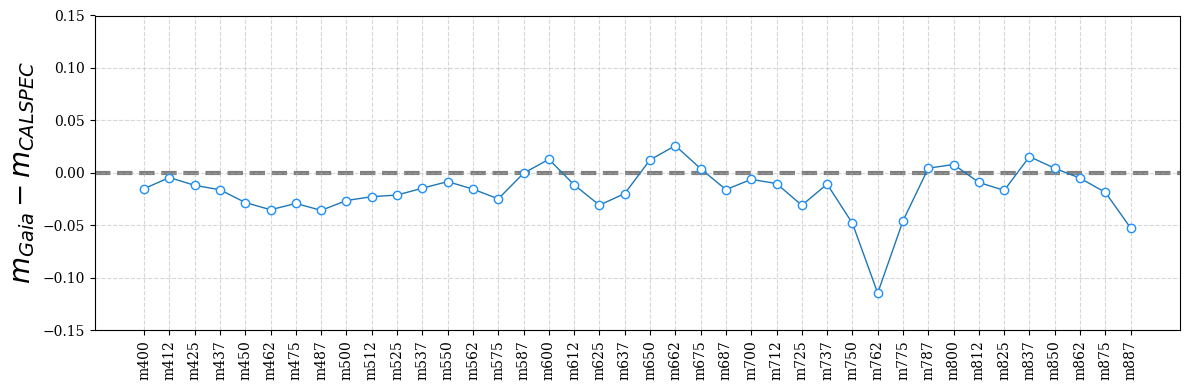

In [59]:
xarr = np.arange(len(mobstbl['filter']))

fig = plt.figure(figsize=(12, 4))

delmaglist = []
for filte in mobstbl['filter']:
	mag_calspec = mobstbl['magapp'][mobstbl['filter']==filte].item()
	mag_gaia = reftbl[f"{filte}_mag"][indx_ref]

	delmag = mag_gaia - mag_calspec
	delmaglist.append(delmag)

plt.axhline(y=0, ls='--', lw=3, alpha=0.5, zorder=0, color='k')
plt.plot(xarr, delmaglist, 'o-', mfc='w', mec='dodgerblue', lw=1)
plt.ylabel(r"$m_{Gaia}-m_{CALSPEC}$")
plt.ylim(-0.15, 0.15)
_ = plt.xticks(xarr, mobstbl['filter'], rotation=90)
plt.grid('both', ls='--', alpha=0.5)
plt.tight_layout()

plt.savefig(f"{path_save}/comp_gaia_calspec.png",)